In [3]:

import modal.models
from modal.models import ActiveLearner
from modal.uncertainty import uncertainty_sampling
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import utils

from copy import deepcopy

import random
from importlib import reload
from helpers import *

In [2]:
# import the dataset as a pandas dataframe
fpath = 'Ti-Nb-V-Ta-Fe-Sb_sputtering_data_complete_clean.csv'

df = pd.read_csv(fpath,header=0)

# select the input variables to train on
# if you want to run a model on a reduced parameter set, comment out some of the input training variables
train_variables = ['Ta_power_watts','Sb_power_watts','Nb_power_watts','Ti_power_watts','Fe_power_watts','V_power_watts',
                   'Ta_angle_mm','Sb_angle_mm','Nb_angle_mm','Ti_angle_mm','Fe_angle_mm','V_angle_mm']
predict_variables = ['Ta_measured_percent','Sb_measured_percent','Nb_measured_percent','Ti_measured_percent','Fe_measured_percent','V_measured_percent']
variable_names = ['Ta','Sb','Nb','Ti','Fe','V']

# ingest the full dataset
X_all,y_all = ingest_sputtering_data(fpath,train_variables = train_variables,predict_variables = predict_variables)


# data scaling and pre-processing
X_transformed = np.zeros(X_all.shape)
# scale the X data
for ii,x in enumerate(X_all):
    xScaler = preprocessing.StandardScaler().fit(x.reshape(-1,1))
    X_transformed[ii] = xScaler.transform(x.reshape(-1,1)).reshape(len(x))

# scale the y data
y_transformed = np.zeros(y_all.shape)
Scalers = []

for ii,y in enumerate(y_all):
    Scaler = preprocessing.StandardScaler().fit(y.reshape(-1,1))
    y_transformed[ii] = Scaler.transform(y.reshape(-1,1)).reshape(len(y))
    Scalers.append(Scaler)

X_data = X_transformed.T 
Y_data = y_transformed.T
y_original = y_all.T

In [3]:
# Define uncertainty measure for the regressor
def rf_regression_std(learner, X):
    preds = np.array([tree.predict(X) for tree in learner.estimator.estimators_])
    std = np.std(preds, axis=0)
    sum_std = np.array([sum(s) for s in std])
    query_idx = np.argmax(sum_std)
    return query_idx, X[query_idx]

In [4]:
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor

# choose target compositions that you are trying to manufacture
# for this example we have six different samples that we want to synthesize
target_indices = [21,23,24,31,64,66]

# for storing the errors and uncertainties
all_mae_list = []
all_target_mae = []
all_unc_idx = []


for ii,target_index in enumerate(target_indices):

    # first deep copy the entire datasets
    X_data = deepcopy(X_transformed.T) 
    Y_data = deepcopy(y_transformed.T)
    y_original = deepcopy(y_all.T)

    # deep copy the inputs and outputs of the target sample
    target_X = deepcopy(X_data[target_index])
    target_y = deepcopy(y_original[target_index])

    # now remove the target sample from the dataset
    X_data = np.delete(X_data,target_index,axis=0)
    Y_data = np.delete(Y_data,target_index,axis=0)
    y_original = np.delete(y_original,target_index,axis=0)

    # Select 5 random initial data points
    np.random.seed(100)
    train_idx = np.arange(0,6)
    train_idx = np.concatenate([train_idx,np.random.choice(range(6,len(X_data)), 2, replace=False)])
    X_train = X_data[train_idx]
    Y_train = Y_data[train_idx]

    # Remaining data
    X_untrained = np.delete(X_data, train_idx, axis=0)
    Y_untrained = np.delete(Y_data, train_idx, axis=0)
    Y_original_untrained = np.delete(y_original, train_idx, axis=0)

    # Define the regression approach
    model = BaggingRegressor(ExtraTreesRegressor(n_estimators=250), n_estimators=10, bootstrap=True, n_jobs=-1)
    # for now we are going to regress all inputs to all outputs
    # Initialize the active learner
    learner = ActiveLearner(
    estimator=model,
    X_training=X_train, y_training=Y_train,
    query_strategy=rf_regression_std)

    mae_list = []
    target_mae_list = []
    unc_idx = []

    # active learning
    for i in range(len(X_untrained)-1):
        # find the next sample to test based on the improvement of Sb
        query_idx, query_instance = learner.query(X_untrained)
        unc_idx.append(query_idx)

        # get the y value
        y_query = Y_untrained[query_idx]
        
        # update the regressor
        learner.teach([query_instance], [y_query])

        # now remove these samples from the datasets
        X_untrained = np.delete(X_untrained,query_idx,axis=0)
        Y_untrained = np.delete(Y_untrained,query_idx,axis=0)
        Y_original_untrained = np.delete(Y_original_untrained, query_idx, axis=0)

        # okay now make a prediction on the remaining data in the sampling dataset
        y_predict = learner.predict(X_untrained)

        # make predictions on the target
        y_tpred = learner.predict([target_X])

        y_inverted = []
        y_tinverted = []
        for y,y_t,Scaler,ii in zip(y_predict.T,y_tpred[0],Scalers,range(6)):
            y_inverted.append(Scaler.inverse_transform(y.reshape(-1,1)).reshape(len(y)))
            y_tinverted.append(Scaler.inverse_transform(np.array([y_t]).reshape(1,-1)))
        y_inverted = np.array(y_inverted).T
        y_tinverted = np.array(y_tinverted).T

        # calculate the target MAE
        target_mae = np.mean(np.abs(y_tinverted - target_y))
        target_mae_list.append(target_mae)
        
        # Calculate MAE
        mae = np.mean(np.abs(y_inverted - Y_original_untrained))
        mae_list.append(mae)

    all_target_mae.append(target_mae_list)
    all_mae_list.append(mae_list)
    all_unc_idx.append(unc_idx)

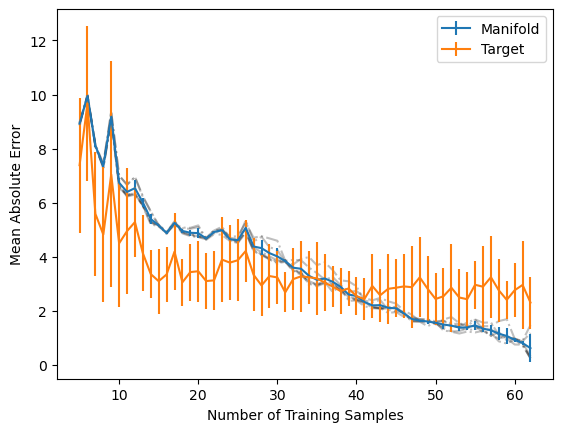

In [5]:
# make a plot of the error both for the targets and for the manifold
mean_target_mae = np.array([np.mean(array) for array in np.array(all_target_mae).T]) 
mean_mae_list = np.array([np.mean(array) for array in np.array(all_mae_list).T]) 

mean_target_std = np.array([np.std(array) for array in np.array(all_target_mae).T])
mean_mae_std = np.array([np.std(array) for array in np.array(all_mae_list).T]) 


plt.figure()

for mae_list in all_mae_list:
    plt.plot(np.arange(len(mae_list))+5,mae_list,'k-.',alpha=0.25)

plt.errorbar(np.arange(len(mean_mae_list))+5,mean_mae_list,yerr=mean_mae_std,label='Manifold')
plt.errorbar(np.arange(len(mean_target_mae))+5,mean_target_mae,yerr=mean_target_std,label='Target')

plt.xlabel('Number of Training Samples')
plt.ylabel('Mean Absolute Error')
plt.legend()

In [6]:
# save the errors
mae_df = pd.DataFrame({'mae':mean_mae_list,'yerr':mean_mae_std})
mae_df.to_csv('errors/RFDT_regression_error_averaged_six_runs.csv',index=False)

target_mae_df = pd.DataFrame({'target_mae':mean_target_mae,'yerr':mean_target_std})
target_mae_df.to_csv('errors/RFDT_regression_target_error_averaged_six_runs.csv',index=False)